# Check emission pairs to see which are missing in construction

In [155]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm, setup_ind_scm
from src.utils.sem_utils.emissions import get_emissions_input_output_pairs
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.emissions import fit_sem_emit_fncs
from numpy.random import seed
from src.utils.utilities import powerset


seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


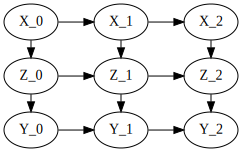

In [181]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_stat_scm(T=3)
# This is just a snapshot of the DAG at hand
dag_view

In [162]:
dag.add_edge("Z_0","X_0")
dag.add_edge("Z_1","X_1")
dag.add_edge("Z_2","X_2")

dag.remove_edge("X_0","Z_0")
dag.remove_edge("X_1","Z_1")
dag.remove_edge("X_2","Z_2")

In [176]:
dag.add_edge("X_0","Y_0")
dag.add_edge("X_1","Y_1")
dag.add_edge("X_2","Y_2")

0

In [139]:
node_children, node_parents, emission_pairs = get_emissions_input_output_pairs(T, dag)
emission_pairs

{('Z_0',): 'Y_0',
 ('X_0',): 'Y_0',
 ('Z_1',): 'Y_1',
 ('X_1',): 'Y_1',
 ('Z_2',): 'Y_2',
 ('X_2',): 'Y_2'}

In [182]:

# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[ 1.76405235,  2.16420955,  3.14294754],
        [ 0.4105985 ,  0.55464207,  2.00891558],
        [ 0.3130677 , -0.54102804, -3.09401785],
        [-0.18718385,  1.34559536,  2.81495413],
        [ 1.23029068,  2.43267053,  2.04534371]]),
 'Z': array([[ 2.41224229e+00,  4.39464095e+00,  3.46051848e+00],
        [ 1.42429090e+00,  2.12024369e+00,  2.69824097e+00],
        [ 1.38481900e+00,  3.96702709e+00,  2.52904184e+01],
        [ 1.36079639e+00,  1.99934354e+00,  1.17146526e+00],
        [-1.00951244e-02, -9.70846048e-01, -2.26152826e+00]]),
 'Y': array([[-0.68189676, -1.94841594, -3.84232337],
        [-0.45160585, -0.37915648, -2.36142647],
        [ 1.52155989, -1.43112523, -0.68014656],
        [-2.7065599 , -4.374889  , -4.77284705],
        [-1.70682603, -0.24118898, -2.50766016]])}

# Convert to adjacency matrix and get all relationships from that

In [112]:
from networkx.linalg.graphmatrix import adjacency_matrix
from networkx.convert import to_dict_of_lists
import numpy as np
from scipy.linalg import block_diag 
from src.utils.dag_utils.adjacency_matrix_utils import get_emit_and_trans_adjacency_mats

In [ ]:
def func(G):
    # Standard
    A = adjacency_matrix(G)
    # In array form 
    AA = np.asarray(A.todense())
    # List of all nodes in G
    nodes = np.array(dag.nodes())
    # List of all leaf/source nodes/vertices in G (confounders are not included)
    sources = nodes[~AA.sum(axis=0).astype(bool)].tolist()

    # Get all input-output tuples

In [3]:
dag.add_node("W_1")
dag.add_edge("W_1","X_1")

In [53]:
A = adjacency_matrix(dag)
AA = np.asarray(A.todense())

In [87]:
gg = dag.subgraph(['X_0', 'Z_0', 'Y_0', 'X_1', 'Z_1', 'Y_1'])
a = adjacency_matrix(gg)
aa = np.asarray(a.todense())
aa

array([[0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]])

In [111]:
gg.nodes()

NodeView(('X_0', 'Z_0', 'Y_0', 'X_1', 'Z_1', 'Y_1'))

In [177]:
nodes = np.array(dag.nodes())
E_A_mat, _, T = get_emit_and_trans_adjacency_mats(dag)
E_A_mat

array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [180]:

# Each node in this list is a parent to more than one child node
fork_idx = np.where(E_A_mat.sum(axis=1) > 1)[0]
fork_nodes = nodes[fork_idx]
print(fork_nodes, fork_idx)
for i in fork_idx:
    print(nodes[np.where(E_A_mat[i,:] == 1)])


['X_0' 'X_1' 'X_2'] [0 3 6]
['Z_0' 'Y_0']
['Z_1' 'Y_1']
['Z_2' 'Y_2']


In [161]:
for i, v in enumerate(nodes):
    kk = [vv.split("_")[0] for vv in nodes[np.where(E_A_mat[:, i] == 1)[0]]]
    if len(kk) == 0:
        pass
    else:
        print('hi')
    # print(list(dag.predecessors(v)))

hi
hi
hi
hi
hi
hi


In [171]:
to_dict_of_lists(dag)

{'X_0': ['X_1'],
 'Z_0': ['Y_0', 'Z_1', 'X_0'],
 'Y_0': ['Y_1'],
 'X_1': ['X_2'],
 'Z_1': ['Y_1', 'Z_2', 'X_1'],
 'Y_1': ['Y_2'],
 'X_2': [],
 'Z_2': ['Y_2', 'X_2'],
 'Y_2': []}

In [184]:
from sklearn.neighbors import KernelDensity
X = D_Obs['X'][:,0].reshape(-1,1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)

In [196]:
kde.sample()

array([[-1.00228302]])